<a href="https://colab.research.google.com/github/amelia188/DataAnalysis/blob/master/MLP_Waterlevel_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP Waterlevel Prediction

## Setup

In [ ]:
# @title
# Import required libraries

!pip install tensorflow
!pip install scikeras
!pip install sklearn

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

## Training the Model

In [ ]:
# @title
# Load the dataset
df = pd.read_excel("/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/Merged Soil Moisture & Weather Data.xlsx")

# Remove rows with missing or non-numeric data
df_clean = df.apply(pd.to_numeric, errors='coerce')
df_clean.dropna(inplace=True)

# Define the target variable and features
target_column = 'Water level - m'  # Adjust the column name as needed
Y = df_clean[[target_column]]
features = df_clean[['Rain - in', 'Temp - °F']]  # Assuming these are the relevant features
X = features

# Function to create a deeper model
def deeper_model(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_shape=(input_dim,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Initialize the pipeline with standardization and the Keras model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=lambda: deeper_model(X.shape[1]), epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)



In [ ]:
# Evaluate model with cross-validation
cv_scores = cross_val_score(pipeline, X, Y, cv=10, scoring='neg_mean_squared_error')

# Print cross-validation results
print("CV Scores:", cv_scores)
print("CV Mean:", cv_scores.mean())
print("CV Standard Deviation:", cv_scores.std())

# Fit the pipeline on the entire dataset (for demonstration; typically, you'd use train/test split)
pipeline.fit(X, Y.values.ravel())



In [ ]:
# Assuming `weather_data_prepared` is your new data for prediction, structured like `X`
waterlevel_data_prepared = pd.DataFrame({'Rain - in': [0.5], 'Temp - °F': [75]})
waterlevel_predictions = pipeline.predict(waterlevel_data_prepared)

# Display predictions
print(waterlevel_predictions)

## Plot Waterlevel Predictions

0   2023-03-01 00:00:00
1   2023-03-01 01:00:00
2   2023-03-01 02:00:00
3   2023-03-01 03:00:00
4   2023-03-01 04:00:00
Name: Date & Time, dtype: datetime64[ns]
(4309,)
(4309,)
                 Date  Predicted Soil Moisture
0 2023-03-01 00:00:00                 0.584001
1 2023-03-01 01:00:00                 0.644262
2 2023-03-01 02:00:00                 0.644262
3 2023-03-01 03:00:00                 0.644262
4 2023-03-01 04:00:00                 0.644262


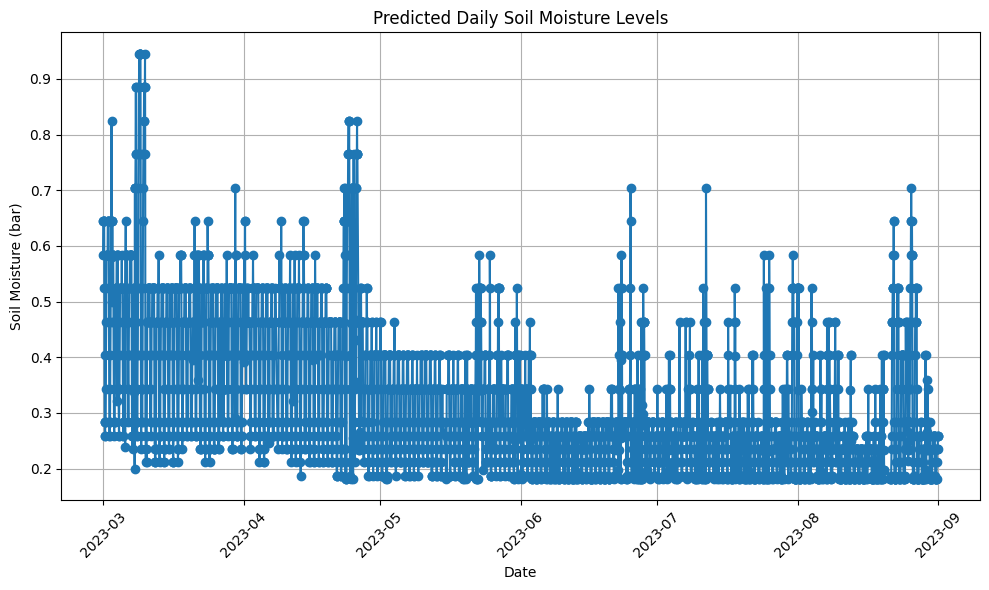

In [ ]:
# @title
import matplotlib.pyplot as plt
import pandas as pd

# Convert the nanosecond timestamps to datetime format
dates_converted = pd.to_datetime(df_clean['Date & Time'], unit='ns')

# Create the DataFrame directly using the 'Date & Time' column and the predictions
predictions_df = pd.DataFrame({
    'Date': dates_converted,  # Assuming 'Date & Time' column exists and is formatted correctly
    'Predicted Waterlevel': waterlevel_predictions.flatten()  # Flatten ensures it's a 1D array for sure
})


# Now 'dates_converted' will contain datetime objects instead of the large integers
print(dates_converted.head())  # Display the first few converted dates to verify

# Print shapes of 'Date' and 'Predicted Soil Moisture' columns to verify
print(predictions_df['Date'].shape)
print(predictions_df['Predicted Waterlevel'].shape)

# Display the DataFrame
print(predictions_df.head())

plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted Waterlevel'], marker='o', linestyle='-')
plt.title('Predicted Daily Water Levels')
plt.xlabel('Date')
plt.ylabel('Water Level m')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
